# Matching Halo Quantities from Skysim to CosmoDC2

Here I show how to match the halos between cosmoDC2 and Skysim to correct for duplicate halos or to incoporate SOD quantities. I'm going to start with a caveat here: DC2 (the image simulation) exactly matches cosmoDC2, bugs and all. As the cosmoDC2 catalog doesn't incorporate halo shapes, the skysim shapes aren't carried through to DC2, and removing duplicates from cosmoDC2 is only recommended if you treat the corresponding DC2 area carefully. Proceed with caution!

Owner: Patricia Larsen

Last verified run: April 26, 2024 by @patricialarsen

This notebook uses the Generic Catalog Reader (GCR, https://github.com/yymao/generic-catalog-reader) to access halo quantities. For more assistance with using GCR please see https://github.com/LSSTDESC/gcr-catalogs/blob/master/examples/GCRCatalogs%20Demo.ipynb

**Objectives:**

After working through and studying this Notebook you should be able to

- Match cosmoDC2 halos to their skysim quantities
- Get a list of duplicate halos from cosmoDC2


Logistics: This notebook is intended to be run through the JupyterHub NERSC interface available here: https://jupyter.nersc.gov. To setup your NERSC environment, please follow the instructions available here: https://confluence.slac.stanford.edu/display/LSSTDESC/Using+Jupyter+at+NERSC

**TLDR: you can skip most of the discussions, look at sections titled match skysim properties, or putting it all together for the codes needed**

In [182]:
import GCRCatalogs
import numpy as np
from astropy.table import Table
from GCR import GCRQuery
import matplotlib.pyplot as plt
%matplotlib inline


### Preamble

I'm going to load the data without much comment, for full details on these quantities and the read-in, please look at the extragalactic_halo_quantities tutorial. Notably though we're keeping the x,y,z, vx, vy, vz quantities, masses and simulation ID values 
to match (and test matching of) the catalogs, along with a couple of sod quantities. We are filtering by "is_central" to keep only the set of halo quantities and limiting ourselves to the small catalog and z<0.5 for this test. I've chosen not to filter on mass so that we can 
see the mass dependence of the duplicate issue and the SOD quantities. 

**Important note**
Please make sure you're reading in the same sky area for each catalog. Use the _image or _small catalogs 

In [183]:
gc_cdc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
gc_sky = GCRCatalogs.load_catalog('skysim5000_v1.2_small')


In [184]:

cluster_data = gc_cdc2.get_quantities(['ra','dec', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'redshift', 'halo_mass', 'halo_id','baseDC2/target_halo_mass','baseDC2/target_halo_id',
                                      'baseDC2/target_halo_fof_halo_id', 'lightcone_replication', 'step'], 
                                 filters=['is_central','redshift < 0.5']) 

cluster_data_sky = gc_sky.get_quantities(['ra','dec', 'x', 'y', 'z',  'vx', 'vy', 'vz', 'redshift', 'halo_mass', 'halo_id','baseDC2/target_halo_mass','baseDC2/target_halo_id',
                                       'baseDC2/target_halo_fof_halo_id', 'baseDC2/sod_halo_mass','baseDC2/sod_halo_cdelta',  'lightcone_replication', 'step'], 
                                 filters=['is_central','redshift < 0.5']) 


### Match Skysim properties to CosmoDC2 halos 

The target_halo_fof_halo_id is the base ID from the simulation, so it can be used alongside the lightcone replication and the simulation step to match halo masses etc. You should be careful to match the replication and step and not just the tag. 

Let's assume a selection here of >5x10^14 Msun/h mass halos, just so we can look at the values more easily. First we must make a unique identifier for each halo 

In [185]:
cosmodc2_halos_tag = cluster_data['baseDC2/target_halo_fof_halo_id'][cluster_data['halo_mass']>5.e14]
cosmodc2_halos_step = cluster_data['step'][cluster_data['halo_mass']>5.e14]
cosmodc2_replication = cluster_data['lightcone_replication'][cluster_data['halo_mass']>5.e14]
nhalos = len(cosmodc2_halos_tag)

cosmodc2_unique_identifier = np.array([str(cosmodc2_halos_tag[i])+ str('_') + str(cosmodc2_halos_step[i])+ str('_') + str(cosmodc2_replication[i]) for i in range(nhalos)])

skysim_halos_tag = cluster_data_sky['baseDC2/target_halo_fof_halo_id'][cluster_data_sky['halo_mass']>5.e14]
skysim_halos_step = cluster_data_sky['step'][cluster_data_sky['halo_mass']>5.e14]
skysim_replication = cluster_data_sky['lightcone_replication'][cluster_data_sky['halo_mass']>5.e14]
nhalos = len(skysim_halos_tag)

skysim_unique_identifier = np.array([str(skysim_halos_tag[i])+ str('_') + str(skysim_halos_step[i])+ str('_') + str(skysim_replication[i]) for i in range(nhalos)])


Now *for the halos that are common across the simulations* (this is everything except the duplicate bug halos mentioned below, and for lower mass halos due to resolution issues or cuts), we can create a common ordering with numpy's intersect1d function

In [186]:
identifiers, idx1, idx2 = np.intersect1d(cosmodc2_unique_identifier, skysim_unique_identifier,return_indices=True, assume_unique=False)

We now confirm this is working as expected, and use it to plot the SOD/FOF mass relation for the (unduplicated) cosmoDC2 halos

In [187]:
print((cosmodc2_unique_identifier[idx1]==skysim_unique_identifier[idx2]).all())
print((cluster_data['halo_mass'][cluster_data['halo_mass']>5.e14][idx1] ==cluster_data_sky['halo_mass'][cluster_data_sky['halo_mass']>5.e14][idx2]).all())

True
True


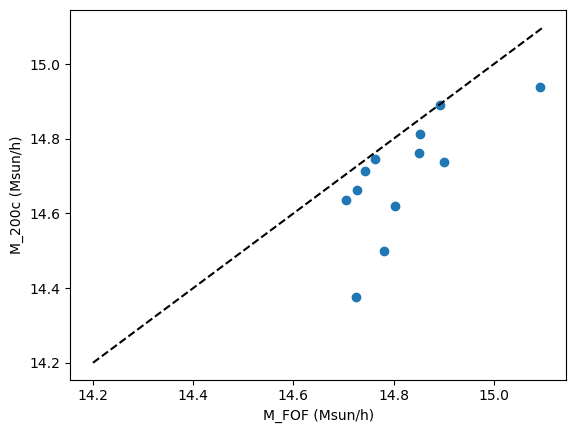

In [188]:
# h factor here is due to unit difference between native and non-native quantities. 
h = gc_sky.cosmology.H0.value/100.
cosmodc2_halo_fof_masses = cluster_data['halo_mass'][cluster_data['halo_mass']>5.e14][idx1]
cosmodc2_halo_sod_masses = cluster_data_sky['baseDC2/sod_halo_mass'][cluster_data_sky['halo_mass']>5.e14][idx2]/h

plt.figure()
plt.scatter(np.log10(cosmodc2_halo_fof_masses),np.log10(cosmodc2_halo_sod_masses))
plt.plot(np.linspace(14.2,15.1,100),np.linspace(14.2,15.1,100),'k--')
plt.xlabel("M_FOF (Msun/h)")
plt.ylabel("M_200c (Msun/h)")
plt.show()


### Find those duplicates!

Let's start by showing how you can identify a rare issue that affected some cluster-mass halos in the cosmoDC2 catalog. 

First some background:

In the merger-tree creation we often divide halos into fragments, to identify halos that may not fully merge in, but are temporarily associated with each other as they move past one another. Most high-mass halos have some number of fly-by events and so themselves are classified as fragment objects for the purposes of the merger tree. The most massive fragment of the total object will be given ownership of the whole FOF halo, and the position as it crosses the lightcone will be determined by that fragment's location. 

Now, in creating the lightcone we run on a large number of ranks, and sometimes fragments of the same object will live on different ranks. In rare cases you might have two equal-mass fragments in which case the decision of the most-massive fragment is arbitrary, and so when deciding if the halo should exist on this rank or its neighbor, the different ranks didn't always make the same decision and both ranks took ownership, creating a duplicate halo.   

One way to look at the uniqueness of halos is to look at the fof halo IDs from the simulation. However you have to be a little careful with lightcone halos, as the fof halo IDs are only unique for a given redshift step and box replication. But if we look at the masses and positions and they are both equal this duplication has occured. 


In [189]:
val, counts = np.unique(cluster_data['halo_mass'][cluster_data['halo_mass']>5.e14],return_counts=True)
print(val[counts==2][0])
print(" ")
print("Properties of potential duplicate halo")
print("--------------------------------------")
mask_duplicate = cluster_data['halo_mass']==val[counts==2][0]
for key in ['x','y','z']:
    print(key,cluster_data[key][mask_duplicate])
for key in ['vx','vy','vz']:
    print(key,cluster_data[key][mask_duplicate])
print(" ")
print("Masses of potential duplicate halo")
print("--------------------------------------")

for key in ['halo_mass','baseDC2/target_halo_mass']:
    print(key,cluster_data[key][mask_duplicate])


554430418863233.8
 
Properties of potential duplicate halo
--------------------------------------
x [187.99482727 187.96554565]
y [360.93951416 360.88204956]
z [-327.67745972 -327.75216675]
vx [213.37700993 356.05765905]
vy [607.76057317 788.58024518]
vz [464.12533198 126.00830435]
 
Masses of potential duplicate halo
--------------------------------------
halo_mass [5.54430419e+14 5.54430419e+14]
baseDC2/target_halo_mass [3.93645597e+14 3.93645597e+14]


These are around 100kpc apart, consistent with fragments of the same halo. The velocities differ a little as they're different fragments, and the masses are exactly the same (note unit differences between the two measurements).

In [190]:
val, counts = np.unique(cluster_data['halo_mass'][cluster_data['halo_mass']>5.e14],return_counts=True)
print(val[counts==2][0])
print(" ")
print("ID values of potential duplicate halo")
print("--------------------------------------")
mask_duplicate = cluster_data['halo_mass']==val[counts==2][0]
for key in ['halo_id','baseDC2/target_halo_id','baseDC2/target_halo_fof_halo_id']:
    print(key,cluster_data[key][mask_duplicate])


554430418863233.8
 
ID values of potential duplicate halo
--------------------------------------
halo_id [ 55300142421 167900142421]
baseDC2/target_halo_id [ 55300142421 167900142421]
baseDC2/target_halo_fof_halo_id [127303414854 130659124278]


Note that these have unique ID values (and that the target_halo_id and fof_tag are somewhat different). This means that the IDs can't be found using cosmoDC2 data alone, except by mass/position matches. However we can use skysim data to identify them.. 


Let's look at the same properties for the Skysim catalog, when we look for the same mass we only get one object, with the same properties as one of the cosmoDC2 objects. This is the bug-corrected catalog where this duplicate doesn't exist. 

In [191]:
print(" ")
print("Properties of potential duplicate halo (skysim)")
print("--------------------------------------")
mask_duplicate = cluster_data_sky['halo_mass']==val[counts==2][0]
for key in ['x','y','z']:
    print(key,cluster_data_sky[key][mask_duplicate])
for key in ['vx','vy','vz']:
    print(key,cluster_data_sky[key][mask_duplicate])
print(" ")
print("Masses of potential duplicate halo")
print("--------------------------------------")

for key in ['halo_mass','baseDC2/target_halo_mass']:
    print(key,cluster_data_sky[key][mask_duplicate])
print(" ")
print("ID values of potential duplicate halo")
print("--------------------------------------")

mask_duplicate = cluster_data_sky['halo_mass']==val[counts==2][0]
for key in ['halo_id','baseDC2/target_halo_id','baseDC2/target_halo_fof_halo_id']:
    print(key,cluster_data_sky[key][mask_duplicate])


 
Properties of potential duplicate halo (skysim)
--------------------------------------
x [187.97261047]
y [360.89770508]
z [-327.75466919]
vx [356.05758667]
vy [788.58013916]
vz [126.00830841]
 
Masses of potential duplicate halo
--------------------------------------
halo_mass [5.54430419e+14]
baseDC2/target_halo_mass [3.93645597e+14]
 
ID values of potential duplicate halo
--------------------------------------
halo_id [144309942421]
baseDC2/target_halo_id [144309942421]
baseDC2/target_halo_fof_halo_id [130659124278]


### Method

So the idea is that we can use the skysim catalog as a check to see if the halo should exist or not and get a list of "fake" halos. We have to be careful of three things that can affect our results though:

- The fof halo tag of a "bad" object may exist in a different lightcone replication or redshift of the skysim catalog
- Mass cuts, or other imposed cuts on galaxy luminosity can prevent a "good" halo tag from existing in skysim

Keeping those in mind, let's add the step and replication to the inputs (with the benefit of hindsight they're already in memory) and try this:

In [192]:
print(' ')
for item in gc_cdc2.list_all_native_quantities():
    if 'rep' in item:
        print(item)
print(' ')
for item in gc_cdc2.list_all_native_quantities():
    if 'step' in item:
        print(item)

 
lightcone_replication
baseDC2/lightcone_replication
 
step


In [193]:
bad_ids = np.array([])
bad_reps = np.array([])
bad_steps =  np.array([])

replication_list = np.unique(cluster_data['lightcone_replication'])
step_list = np.unique(cluster_data['step'])

for rep in replication_list:
    for step in step_list:
        mask_sample = (cluster_data['lightcone_replication']==rep)&(cluster_data['step']==step)
        mask_sample_sky = (cluster_data_sky['lightcone_replication']==rep)&(cluster_data_sky['step']==step)
        fof_tags = cluster_data['baseDC2/target_halo_fof_halo_id'][mask_sample]
        fof_tags_sky = cluster_data_sky['baseDC2/target_halo_fof_halo_id'][mask_sample_sky]
        
        mask_bad = np.logical_not(np.isin(fof_tags,fof_tags_sky))
        bad_ids = np.concatenate((fof_tags[mask_bad],bad_ids))
        bad_reps = np.concatenate((np.ones(np.sum(mask_bad),dtype='int')*rep,bad_reps))
        bad_steps = np.concatenate((np.ones(np.sum(mask_bad),dtype='int')*step,bad_steps))
        

### But wait there's more!

The bad ids here are actually a combination of duplicates and IDs that aren't found in skysim due to cuts, so let's look at them more closely. First let's actually check from cosmoDC2 if there is another object at the same step and replication with equal mass, if so we put it in the list...


In [194]:
print("Number of candidate duplicates: ", len(bad_ids))
duplicates=0

duplicate_masses = []
duplicate_halo_id = []

bad_ids_true=[]
bad_reps_true=[]
bad_steps_true=[]
dists=[]


# I choose to keep a pretty wide range of possible matching distances for this, however note that very low mass halos may be physically close 
# and have equal masses from discretization

for obj in range(len(bad_ids)):
    #find the halo
    idx = np.where((cluster_data['baseDC2/target_halo_fof_halo_id']==bad_ids[obj])&(cluster_data['lightcone_replication']==bad_reps[obj])&(cluster_data['step']==bad_steps[obj]))[0][0]
    # get a comparison sample of objects with the same replication number and step
    mask_comparison = (cluster_data['lightcone_replication']==bad_reps[obj])&(cluster_data['step']==bad_steps[obj])
    # calculate distance of halo sample to halo 
    dist_halos = np.sqrt((cluster_data['x'][mask_comparison] - cluster_data['x'][idx])**2 + (cluster_data['y'][mask_comparison] - cluster_data['y'][idx])**2 + (cluster_data['z'][mask_comparison] - cluster_data['z'][idx])**2)
    # calculate whether mass and distance are both close (exact mass and dist<200kpc)
    mask_dup = (cluster_data['halo_mass'][mask_comparison]==cluster_data['halo_mass'][idx])&(dist_halos<0.2)
    if np.sum(mask_dup)>1:
        # we should have one duplicate exactly (matching to itself), so duplicate means >1
        bad_ids_true.append(bad_ids[obj])
        bad_reps_true.append(bad_reps[obj])
        bad_steps_true.append(bad_steps[obj])
        duplicate_masses.append(cluster_data['halo_mass'][idx])
        duplicate_halo_id.append(cluster_data['halo_id'][idx])
        dists.append(dist_halos[mask_dup][dist_halos[mask_dup]>0])
        duplicates+=1
        
print("Number of final duplicates: ", duplicates)

Number of candidate duplicates:  1711
Number of final duplicates:  7


We see here that low mass halos have a larger separation, especially as the size of a low-mass halo should be pretty low, so these are likely not true duplicates.   

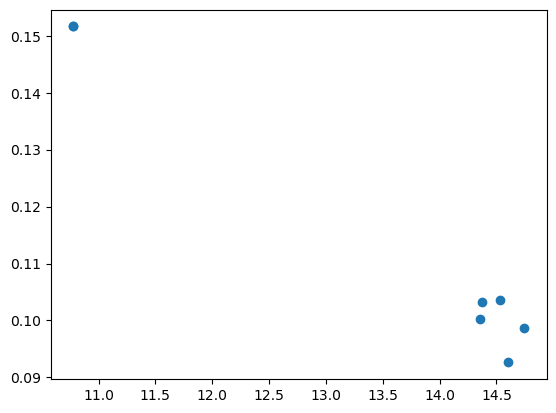

In [195]:
plt.scatter(np.log10(duplicate_masses), np.array(dists))

## Final method:

The best way to check if this is a true duplicate is to confirm that skysim finds objects corresponding to these duplicate candidates - it shouldn't have the exact same object (as this is the definition of duplicate we've enforced), so if there is an object of the same halo mass which is physically close, it must have been a duplicate.

We find that the 5 high mass objects here are true duplicates (i.e. have a corresponding pair in skysim but have a missing ID for being a duplicate), and the lower mass objects are simply neighbouring low-mass halos. 

In [196]:
print("Number of candidate duplicates: ", len(bad_ids))
duplicates=0

duplicate_masses = []
duplicate_halo_id = []
bad_ids_true=[]
bad_reps_true=[]
bad_steps_true=[]
dists=[]

for obj in range(len(bad_ids)):
    #find the halo
    idx = np.where((cluster_data['baseDC2/target_halo_fof_halo_id']==bad_ids[obj])&(cluster_data['lightcone_replication']==bad_reps[obj])&(cluster_data['step']==bad_steps[obj]))[0][0]
    # get a comparison sample of objects with the same replication number and step
    mask_comparison = (cluster_data_sky['lightcone_replication']==bad_reps[obj])&(cluster_data_sky['step']==bad_steps[obj])
    # calculate distance of halo sample to halo 
    dist_halos = np.sqrt((cluster_data_sky['x'][mask_comparison] - cluster_data['x'][idx])**2 + (cluster_data_sky['y'][mask_comparison] - cluster_data['y'][idx])**2 + (cluster_data_sky['z'][mask_comparison] - cluster_data['z'][idx])**2)
    # calculate whether mass and distance are both close (exact mass and dist<200kpc)
    mask_dup = (cluster_data_sky['halo_mass'][mask_comparison]==cluster_data['halo_mass'][idx])&(dist_halos<0.2)
    #print(obj, np.sum(cluster_data_sky['halo_mass'][mask_comparison]==cluster_data['halo_mass'][idx]))
    if np.sum(mask_dup)>0:
        # we should have one duplicate exactly (matching to itself), so duplicate means >1
        bad_ids_true.append(bad_ids[obj])
        bad_reps_true.append(bad_reps[obj])
        bad_steps_true.append(bad_steps[obj])
        duplicate_masses.append(cluster_data['halo_mass'][idx])
        duplicate_halo_id.append(cluster_data['halo_id'][idx])
        dists.append(dist_halos[mask_dup][dist_halos[mask_dup]>0])
        duplicates+=1


        
print("Number of duplicates found in skysim: ", duplicates)

Number of candidate duplicates:  1711
Number of duplicates found in skysim:  5


## Final Steps

Now we have our final list of duplicates, let's take a look at them. Firstly these are all high-mass halos, very much in the cluster regime. This makes sense as the halo will need to cross rank boundaries for the duplicate bug to occur. 

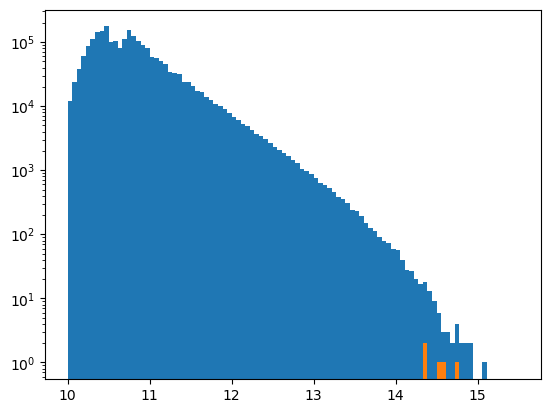

Percentage of > 1.e14 Msun/h mass halos affected =  1.9762845849802373 %


In [197]:
plt.figure()
plt.hist(np.log10(cluster_data_sky['halo_mass']), bins = np.linspace(10,15.5,100))
plt.hist(np.log10(duplicate_masses), bins = np.linspace(10,15.5,100))
plt.yscale('log')
plt.show()
print("Percentage of > 1.e14 Msun/h mass halos affected = ", len(duplicate_masses)/np.sum(cluster_data_sky['halo_mass']>1.e14)*100., "%")

## Putting it all together

Let's put all the important code to output the halo lists together

In [198]:
gc_cdc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')
gc_sky = GCRCatalogs.load_catalog('skysim5000_v1.2_small')

cluster_data = gc_cdc2.get_quantities(['ra','dec', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'redshift', 'halo_mass', 'halo_id','baseDC2/target_halo_mass','baseDC2/target_halo_id',
                                      'baseDC2/target_halo_fof_halo_id', 'lightcone_replication', 'step'], 
                                 filters=['is_central','redshift < 0.5']) 

cluster_data_sky = gc_sky.get_quantities(['ra','dec', 'x', 'y', 'z',  'vx', 'vy', 'vz', 'redshift', 'halo_mass', 'halo_id','baseDC2/target_halo_mass','baseDC2/target_halo_id',
                                       'baseDC2/target_halo_fof_halo_id', 'baseDC2/sod_halo_mass','baseDC2/sod_halo_cdelta',  'lightcone_replication', 'step'], 
                                 filters=['is_central','redshift < 0.5']) 

bad_ids = np.array([])
bad_reps = np.array([])
bad_steps =  np.array([])

replication_list = np.unique(cluster_data['lightcone_replication'])
step_list = np.unique(cluster_data['step'])

for rep in replication_list:
    for step in step_list:
        mask_sample = (cluster_data['lightcone_replication']==rep)&(cluster_data['step']==step)
        mask_sample_sky = (cluster_data_sky['lightcone_replication']==rep)&(cluster_data_sky['step']==step)
        fof_tags = cluster_data['baseDC2/target_halo_fof_halo_id'][mask_sample]
        fof_tags_sky = cluster_data_sky['baseDC2/target_halo_fof_halo_id'][mask_sample_sky]
        
        mask_bad = np.logical_not(np.isin(fof_tags,fof_tags_sky))
        bad_ids = np.concatenate((fof_tags[mask_bad],bad_ids))
        bad_reps = np.concatenate((np.ones(np.sum(mask_bad),dtype='int')*rep,bad_reps))
        bad_steps = np.concatenate((np.ones(np.sum(mask_bad),dtype='int')*step,bad_steps))
        
        
print("Number of candidate duplicates: ", len(bad_ids))
duplicates=0

duplicate_masses = []
duplicate_halo_id = []
bad_ids_true=[]
bad_reps_true=[]
bad_steps_true=[]
dists=[]

for obj in range(len(bad_ids)):
    #find the halo
    idx = np.where((cluster_data['baseDC2/target_halo_fof_halo_id']==bad_ids[obj])&(cluster_data['lightcone_replication']==bad_reps[obj])&(cluster_data['step']==bad_steps[obj]))[0][0]
    # get a comparison sample of objects with the same replication number and step
    mask_comparison = (cluster_data_sky['lightcone_replication']==bad_reps[obj])&(cluster_data_sky['step']==bad_steps[obj])
    # calculate distance of halo sample to halo 
    dist_halos = np.sqrt((cluster_data_sky['x'][mask_comparison] - cluster_data['x'][idx])**2 + (cluster_data_sky['y'][mask_comparison] - cluster_data['y'][idx])**2 + (cluster_data_sky['z'][mask_comparison] - cluster_data['z'][idx])**2)
    # calculate whether mass and distance are both close (exact mass and dist<200kpc)
    mask_dup = (cluster_data_sky['halo_mass'][mask_comparison]==cluster_data['halo_mass'][idx])&(dist_halos<0.2)
    #print(obj, np.sum(cluster_data_sky['halo_mass'][mask_comparison]==cluster_data['halo_mass'][idx]))
    if np.sum(mask_dup)>0:
        # we should have one duplicate exactly (matching to itself), so duplicate means >1
        bad_ids_true.append(bad_ids[obj])
        bad_reps_true.append(bad_reps[obj])
        bad_steps_true.append(bad_steps[obj])
        duplicate_masses.append(cluster_data['halo_mass'][idx])
        duplicate_halo_id.append(cluster_data['halo_id'][idx])
        dists.append(dist_halos[mask_dup][dist_halos[mask_dup]>0])
        duplicates+=1


        
print("Number of duplicates found in skysim: ", duplicates)
print("Halo ids of duplicate halos: ", duplicate_halo_id)


Number of candidate duplicates:  1711
Number of duplicates found in skysim:  5
Halo ids of duplicate halos:  [55300142421, 177000156401, 499100113382, 281100128382, 653000156331]
